# The Heavy-Tail Phenomenon in hSGD


In [1]:
# Required libraries are listed below. 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import normalize
from sklearn import datasets
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.io as scio
from scipy.stats import invgamma
import math
from joblib import Parallel, delayed
from pandas import DataFrame
from time import time

from scipy.stats import t
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot_2samples

In [2]:
"""datasets loading"""
def minist_dataset():
    print("loading MNIST dataset...")
    digits = datasets.load_digits()
    data = digits.data.astype("float")
    ##normalization I
    #data = (data - data.min())/(data.max() - data.min())
    ##normalization II
    #row_norm = np.linalg.norm(data, axis=1, keepdims=True)
    #data = np.divide(data, row_norm)
    #normalization III
    #data = normalize(data)
    print("samples:{}, dimension:{}".format(data.shape[0], data.shape[1]))
    
    """training data and test data"""
    #(trainX, testX, trainY, testY) = train_test_split(data, digits.target, test_size=0.2,random_state = 20,shuffle = True)
    
    label = LabelBinarizer().fit_transform(digits.target)
    
    #testY = LabelBinarizer().fit_transform(testY)
    
    return [data,label]

In [3]:
"""Turn the one-hot to one-dimension"""
def labeltransform(Y):
    y = np.zeros(len(Y))
    for i in range(0,len(Y)-1):
        y_1 = np.nonzero(Y[int(i),:])
        y[int(i)] = y_1[0]
        
    return 0.1*y

In [4]:
"""ReLu activation function"""
def sigma(Z):
    return (np.maximum(Z, 0) - 0.5*(1/np.pi))/(0.5- 0.5*(1/np.pi))

In [5]:
"""dataset we need"""
[X, Y] = minist_dataset()

y = labeltransform(Y)

print('----------------Before----------------')
print(Y[50])

print('\n\n----------------After----------------')
print(y[50])


# total number of data points 
n=X.shape[0]

# features
n_0=X.shape[1]

#feature matrix
d = 200

np.random.seed(1)

W =np.random.randn(n_0, d)
##Random features
A = sigma( np.dot(X, W)/np.sqrt(n_0) )

np.random.seed()

##normalization 
A = (A - A.min())/(A.max() - A.min())


loading MNIST dataset...
samples:1797, dimension:64
----------------Before----------------
[0 0 1 0 0 0 0 0 0 0]


----------------After----------------
0.2


In [6]:
#Singular value decomposition of training data A
P, E, QT = np.linalg.svd(A)
#first sigular value
sv = E[0]
print(sv)


[INFO] SGD interation...
93.48564024773313
        done in 0.001 minutes


In [7]:
"""some parameters"""
#regularization strength
delta = 0
#learning rate
eta = 0.2
b=1

In [8]:
 """upper bound"""
#h_t = 2 *b*n* (sv**2 + n*delta) / (eta * sv**4)+1
h_1 = 2 *b*n* (sv**2  + n*delta) / (eta * sv**4)+1
print(h_1)
#print(int(h_t))

3.056166426902537


In [9]:
 """lower bound"""
Lam = np.dot(E.T, E)
h_2 = 1 + 2 *b*n* (sv**2 + n*delta) / (eta * sv**4)+1 - Lam/sv**2
print(h_2)
#print(int(h_t))

2.7017259215895226


In [10]:
(2 *b*n* (sv**2 + n*delta))/(sv**2 * Lam) # >learning rate

0.30361856705213514

In [11]:
# Loss function
def loss_fn(x,A,y,nsamp,delta):
    res = np.sum((np.dot(A,x) - y)**2)/(2*nsamp) + (delta/2)*np.dot(x,x)
    return res

In [12]:
def sgd_linreg(A,Y,n,d,K,eta,b,delta,compute_loss = False, plot_loss = False):
    loss_sgd = np.zeros(K)
    
    
    x_cur = 0.1 * np.random.randn(d)
    
    
    if(compute_loss is True):
        loss_sgd[0] = loss_fn(x_cur,A,Y,n,delta)

    for k in range(1,K):
        ix = np.random.permutation(n)
        S_k = ix[0:int(b)]
        A_k = A[S_k,:]
        y_k = Y[S_k]
        
        grad = np.dot(A_k.T, np.dot(A_k,x_cur)) - np.dot(A_k.T, y_k) - delta*x_cur
        grad = grad / b
        x_cur = x_cur - eta * grad
        
        if(compute_loss is True):
            loss_sgd[k] = loss_fn(x_cur,A,Y,n,delta)

    x_final = x_cur

    if(plot_loss is True):
        plt.figure()
        plt.semilogy(loss_sgd)
        #plt.plot(loss_sgd)
        
    return x_final

In [13]:
# Number of iteratios
K = 10000

In [17]:
### main result


print("[INFO] SGD interation...")
t0 = time()

# Numer of repetitions

numRep = 1000


x_fn = np.zeros((d,numRep))
loss = np.zeros((K,numRep))


tmp_res = Parallel(n_jobs=10)(delayed(sgd_linreg)(A,y,n,d,K,eta,b,delta,compute_loss= True) for i in range(numRep))
tmp_res = np.array(tmp_res,dtype = object)



print("        done in %0.3f minutes" % ((time() - t0)/60))


[INFO] SGD interation...
        done in 6.648 minutes


In [18]:
Y = np.dot(QT, tmp_res.T)
Z = Y[0,:]
Z = Z - np.average(Z)
Z = Z.astype('float64')

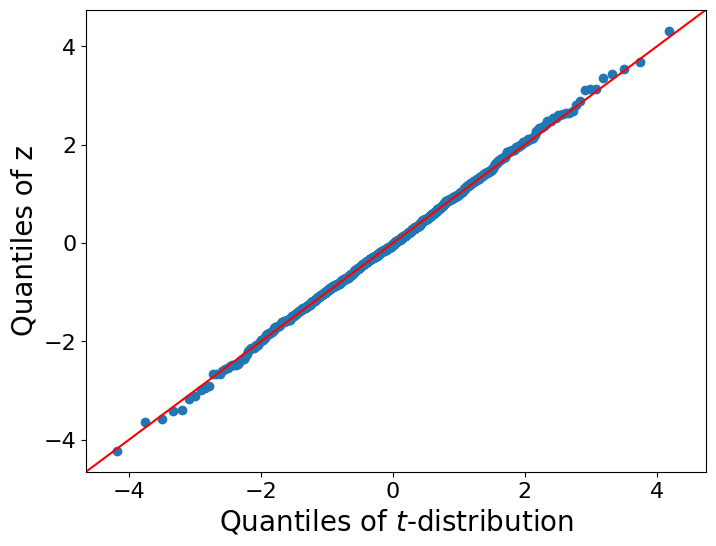

In [22]:
fig = plt.figure(figsize=(8, 6))
axs = fig.subplots(1,1)
sm.qqplot(Z, t,fit=True,line="45", ax = axs)

axs.set_xlabel('Quantiles of $t$-distribution', fontsize = 20)
axs.set_ylabel('Quantiles of z', fontsize = 20)
axs.tick_params(labelsize = 16)

plt.show()